***Савенкова Марина, гр. 932226***




# Задание №5

**Цель работы** – получить навыки обучения и использования архитектур BERT, стека LSTM и двунаправленной LSTM для задач классификации текстовых данных.


##Задание

Обучить нейросетевые модели BERT, стека LSTM, двунаправленную LSTM, предсказывающие авторство текстов по фрагменту текстов.




##Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

In [2]:
import random

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
from google.colab import files
from google.colab import drive

In [5]:
# подключение диска

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/Задание 5/"

In [7]:
# параметры графиков

palette = 'inferno'

colors = sns.color_palette(palette).as_hex()[:]

In [8]:
!pip install bert-for-tf2
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30509 sha256=d9583c35cb72ff936391aeb48d527a85715b88224658d052f3b41d9ccc9ce48d
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19454 sha256=c04957a2b263f81454edb0080256b6ebc7f5b172b6501d540c832b831a8f8fdb
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=48e7af14d35477b33846712c0e41cdcc369f0dd7cf14e064526c9fdb4cb129cb
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [9]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

#Функции

In [10]:
# визуализация процесса обучения

def acc_and_loss_visualization(history, colors):

  clrs = [
      colors[1],
      colors[len(colors) - 1]
    ]

  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_acc, label='Training Accuracy', color = clrs[0])
  plt.plot(epochs, val_acc, label='Validation Accuracy', color = clrs[1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_loss, label='Training Loss', color = clrs[0])
  plt.plot(epochs, val_loss, label='Validation Loss', color = clrs[1])
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

#Анализ данных

In [11]:
poems = pd.read_csv(path + 'poems.csv')

poems.head()

,writer,poem,text
0,Лермонтов Михаил Юрьевич,Любовь мертвеца,NaN
1,Лермонтов Михаил Юрьевич,На серебряные шпоры…,На серебряные шпоры\nЯ в раздумии гляжу;\nЗа т...
2,Лермонтов Михаил Юрьевич,Вид гор из степей Козлова,Пилигрим\nАллах ли там среди пустыни\nЗастывши...
3,Лермонтов Михаил Юрьевич,"К (О, не скрывай! Ты плакала об нем…)","О, не скрывай! Ты плакала об нем –\nИ я его лю..."
4,Лермонтов Михаил Юрьевич,"Жалобы турка (письмо к другу, иностранцу)","Ты знал ли дикий край, под знойными лучами,\nГ..."


In [12]:
poems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19316 entries, 0 to 19315
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   writer  19316 non-null  object
 1   poem    19316 non-null  object
 2   text    19302 non-null  object
dtypes: object(3)
memory usage: 452.8+ KB


In [14]:
poems = poems.dropna()

In [15]:
poems.shape

(19302, 3)

#Отбор авторов и проверка длины текстов

In [119]:
!pip install wordcloud

In [120]:
from wordcloud import WordCloud

In [133]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [134]:
from nltk.corpus import stopwords

In [135]:
russian_stopwords = stopwords.words("russian")

In [136]:
def makeWordCloud(content,title):
    wordcloud = WordCloud(max_words = 200,max_font_size=50,stopwords=russian_stopwords,background_color='white').generate(" ".join(content))
    plt.figure(figsize=(16, 13))
    plt.title(title, fontsize=20)
    plt.imshow(wordcloud.recolor(colormap='Pastel2'), interpolation='bilinear')
    plt.axis("off")


def clearFromStopWords(words,key):
    words = words[~words[key].str.lower().isin(russian_stopwords)]
    words = words[~words[key].str.contains(',','.')]
    return words

In [141]:
def make_word_cloud_from_df(df, label):

  w_df = df.copy()

  words_ = w_df['text'].str.split(expand=True).unstack().value_counts()
  words_ = pd.DataFrame(words_).reset_index(level=0)
  words_.rename(columns={'index':'Word',0:'Count'},inplace=True)

  words_ = clearFromStopWords(words_,"Word")
  words_ = words_[3:]
  words_

  makeWordCloud(w_df.text,"Word Cloud based on " + label)

In [143]:
N_frag = 500

In [144]:
Esenin_df = poems[poems['writer'].str.contains("Есенин")]

In [145]:
Esenin_df = Esenin_df.loc[Esenin_df['text'].str.len() >= 100 ].sample(
    n = N_frag,
    random_state = 1,
    replace = True
  )
Esenin_df.shape

(500, 3)

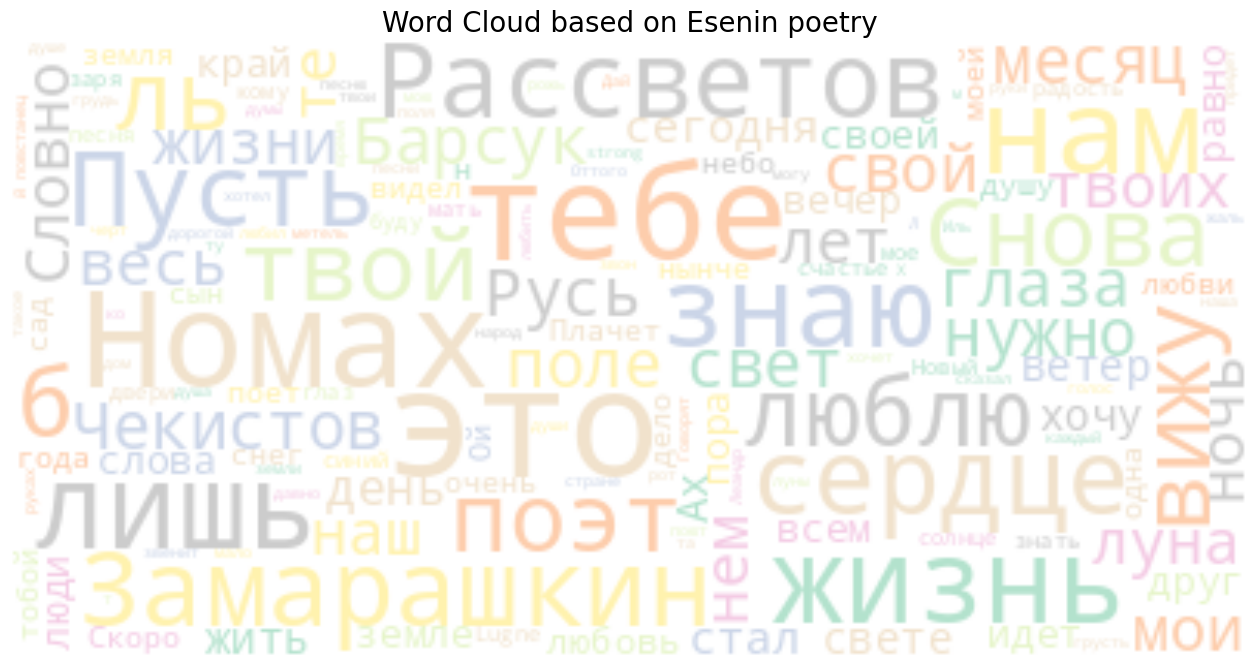

In [146]:
make_word_cloud_from_df(Esenin_df, 'Esenin poetry')

In [147]:
Lermontov_df = poems[poems['writer'].str.contains("Лермонтов")]

In [148]:
Lermontov_df = Lermontov_df.loc[Lermontov_df['text'].str.len() >= 100 ].sample(
    n = N_frag,
    random_state = 1,
    replace = True
  )
Lermontov_df.shape

(500, 3)

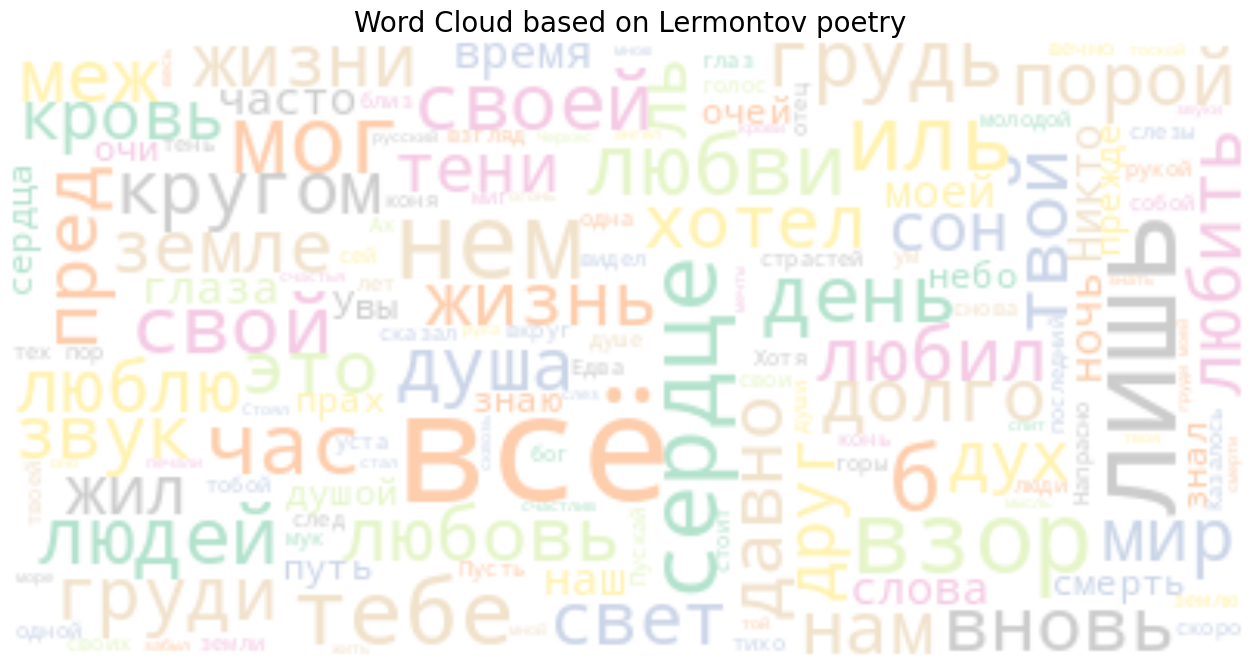

In [149]:
make_word_cloud_from_df(Lermontov_df, 'Lermontov poetry')

In [150]:
Ahmatova_df = poems[poems['writer'].str.contains("Ахматова")]

In [151]:
Ahmatova_df = Ahmatova_df.loc[Ahmatova_df['text'].str.len() >= 100 ].sample(
    n = N_frag,
    random_state = 1,
    replace = True
  )
Ahmatova_df.shape

(500, 3)

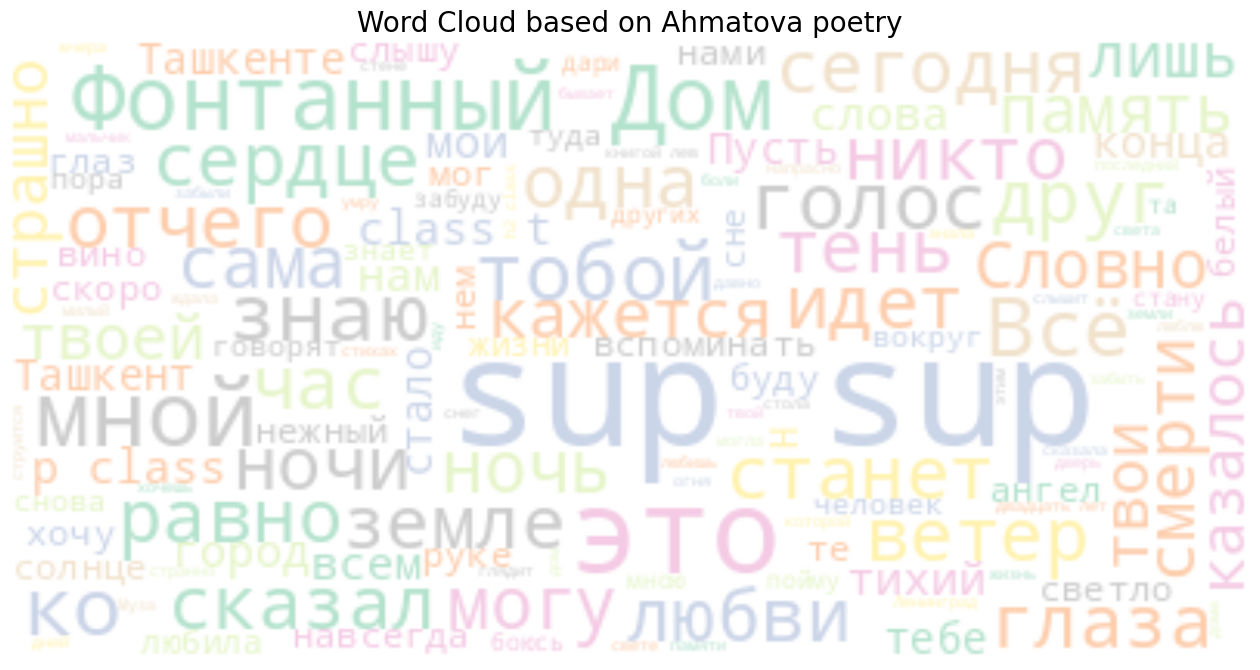

In [153]:
make_word_cloud_from_df(Ahmatova_df, 'Ahmatova poetry')

In [154]:
Blok_df = poems[poems['writer'].str.contains("Блок")]

In [156]:
Blok_df = Blok_df.loc[Blok_df['text'].str.len() >= 100 ].sample(
    n = N_frag,
    random_state = 1,
    replace = True
  )
Blok_df.shape

(500, 3)

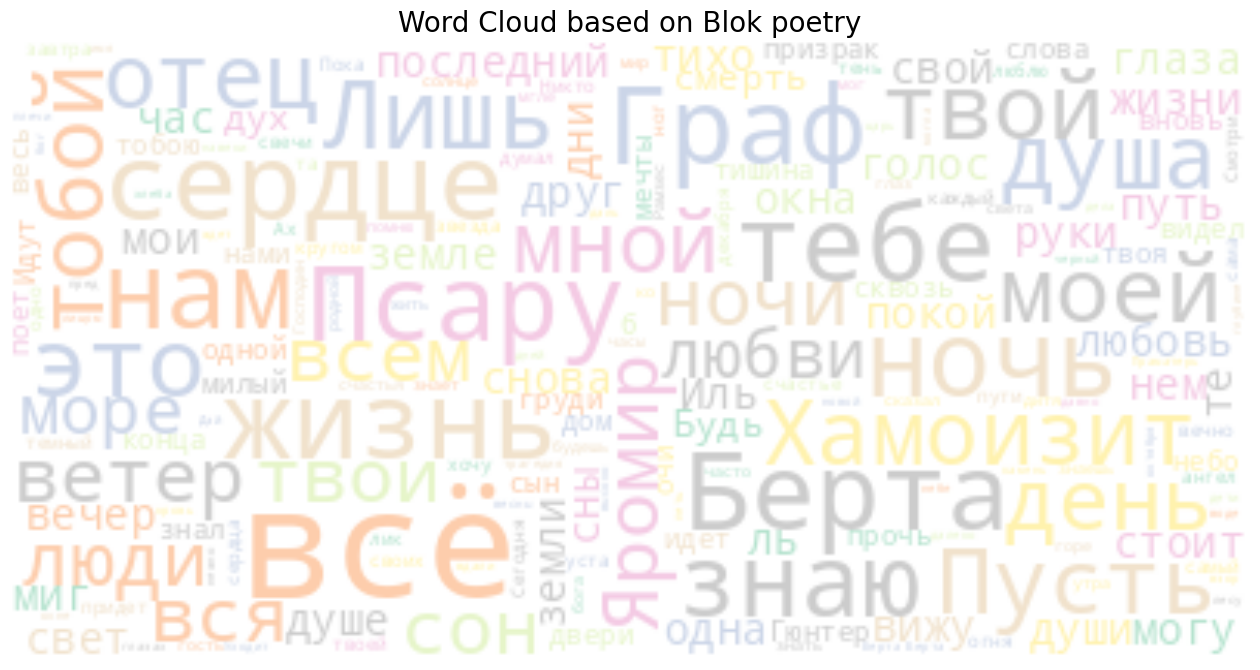

In [157]:
make_word_cloud_from_df(Blok_df, 'Blok poetry')

In [65]:
frames = [Esenin_df, Lermontov_df, Ahmatova_df, Blok_df]

selected_poems_df = pd.concat(frames, ignore_index=True)

In [66]:
selected_poems_df['writer'].unique()

array(['Есенин Сергей Александрович', 'Лермонтов Михаил Юрьевич',
       'Ахматова Анна Андреевна', 'Блок Александр Александрович'],
      dtype=object)

In [67]:
selected_poems_df

,writer,poem,text
0,Есенин Сергей Александрович,"Снег, словно мед ноздреватый…","Снег, словно мед ноздреватый,\nЛег под прямой ..."
1,Есенин Сергей Александрович,Подражанье песне,"Ты поила коня из горстей в поводу,\nОтражаясь,..."
2,Есенин Сергей Александрович,"Песни, песни, о чем вы кричите…","Песни, песни, о чем вы кричите?\nИль вам нечег..."
3,Есенин Сергей Александрович,Брату человеку,"<p class=""t"">Тяжело и прискорбно мне видеть,\n..."
4,Есенин Сергей Александрович,Весенний вечер,Тихо струится река серебристая\nВ царстве вече...
...,...,...,...
1995,Блок Александр Александрович,"Ну, что же Устало заломлены слабые руки…","Ну, что же? Устало заломлены слабые руки,\nИ в..."
1996,Блок Александр Александрович,Восходя на первые ступени…,"Восходя на первые ступени,\nЯ смотрел на линии..."
1997,Блок Александр Александрович,Неомраченный дух прими для лучшей доли…,Неомраченный дух прими для лучшей доли\nТоскую...
1998,Блок Александр Александрович,Глушь родного леса…,"Глушь родного леса,\nЖелтые листы.\nЯркая заве..."


#Кодирование авторов

In [68]:
poems_enc = selected_poems_df.copy()

In [69]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

poems_enc.loc[:, 'writer'] = labelencoder.fit_transform(poems_enc.loc[:, 'writer'])
poems_enc

<ipython-input-69-a076eae53a47>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  poems_enc.loc[:, 'writer'] = labelencoder.fit_transform(poems_enc.loc[:, 'writer'])


,writer,poem,text
0,2,"Снег, словно мед ноздреватый…","Снег, словно мед ноздреватый,\nЛег под прямой ..."
1,2,Подражанье песне,"Ты поила коня из горстей в поводу,\nОтражаясь,..."
2,2,"Песни, песни, о чем вы кричите…","Песни, песни, о чем вы кричите?\nИль вам нечег..."
3,2,Брату человеку,"<p class=""t"">Тяжело и прискорбно мне видеть,\n..."
4,2,Весенний вечер,Тихо струится река серебристая\nВ царстве вече...
...,...,...,...
1995,1,"Ну, что же Устало заломлены слабые руки…","Ну, что же? Устало заломлены слабые руки,\nИ в..."
1996,1,Восходя на первые ступени…,"Восходя на первые ступени,\nЯ смотрел на линии..."
1997,1,Неомраченный дух прими для лучшей доли…,Неомраченный дух прими для лучшей доли\nТоскую...
1998,1,Глушь родного леса…,"Глушь родного леса,\nЖелтые листы.\nЯркая заве..."


In [70]:
labelencoder.classes_

array(['Ахматова Анна Андреевна', 'Блок Александр Александрович',
       'Есенин Сергей Александрович', 'Лермонтов Михаил Юрьевич'],
      dtype=object)

#Разделение на выборки

##Очистка от знаков пунктуации и приведение к нижнему регистру

In [71]:
def processed_texts(texts):

  import string

  processed_texts = []
  for t in texts:
    processed_t = t.translate(str.maketrans('', '', string.punctuation)).lower()
    processed_texts.append(processed_t)

  return processed_texts


In [72]:
#labels = poems_enc['writer']
#texts = poems_enc['text']

In [73]:
labels = poems_enc['writer']
texts = processed_texts(poems_enc['text'])

In [74]:
labels.unique()

array([2, 3, 0, 1])

In [75]:
from sklearn.model_selection import train_test_split

##Разделение данных

In [76]:
# Разбиение данных на обучающий, тестовый и валидационный наборы
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42
  )

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.25,
    random_state=42
  )

#BERT

##Токенизатор

In [77]:
from collections import defaultdict
from transformers import BertTokenizer, TFBertForSequenceClassification, TFBertModel
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample

In [78]:
# Loading the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def encode_texts(tokenizer, texts, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

train_input_ids, train_attention_masks = encode_texts(tokenizer, train_texts)
val_input_ids, val_attention_masks = encode_texts(tokenizer, val_texts)
test_input_ids, test_attention_masks = encode_texts(tokenizer, test_texts)

###BERT с замороженными весами

In [79]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
bert_model.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [83]:
input_ids = Input(shape=(128,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(128,), dtype='int32', name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)[1]

x = Dense(128, activation='relu')(bert_output)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [84]:
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [85]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
  )

In [86]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [87]:
checkpoint_filepath_1 = path + 'models/' + 'untrainable_bert.hdf5'

callbacks = [

    EarlyStopping(
      monitor = 'val_accuracy',
      patience = 30,
      mode = 'max',
      verbose = 1
  ),

    ModelCheckpoint(
      filepath = checkpoint_filepath_1,
      monitor = 'val_accuracy',
      verbose = 1,
      mode = 'max',
      save_best_only = True
  )

]

In [88]:
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': train_input_ids,
    'attention_mask': train_attention_masks
}, train_labels)).shuffle(len(train_input_ids)).batch(64) #размер батча = 32 - зло

val_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': val_input_ids,
    'attention_mask': val_attention_masks
}, val_labels)).batch(64)

In [89]:
test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': test_input_ids,
    'attention_mask': test_attention_masks
}, test_labels)).shuffle(len(test_input_ids)).batch(16)

In [90]:
EPOCHS = 60

# Обучение
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks = callbacks
  )

Epoch 1/60
19/19 [==============================] - ETA: 0s - loss: 1.7327 - accuracy: 0.2617
Epoch 1: val_accuracy improved from -inf to 0.26000, saving model to /content/drive/MyDrive/Задание 5/models/untrainable_bert.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 42s 2s/step - loss: 1.7327 - accuracy: 0.2617 - val_loss: 1.4159 - val_accuracy: 0.2600
Epoch 2/60
19/19 [==============================] - ETA: 0s - loss: 1.4154 - accuracy: 0.2917
Epoch 2: val_accuracy improved from 0.26000 to 0.27250, saving model to /content/drive/MyDrive/Задание 5/models/untrainable_bert.hdf5
19/19 [==============================] - 18s 945ms/step - loss: 1.4154 - accuracy: 0.2917 - val_loss: 1.3782 - val_accuracy: 0.2725
Epoch 3/60
19/19 [==============================] - ETA: 0s - loss: 1.4672 - accuracy: 0.2700
Epoch 3: val_accuracy improved from 0.27250 to 0.31250, saving model to /content/drive/MyDrive/Задание 5/models/untrainable_bert.hdf5
19/19 [==============================] - 18s 955ms/step - loss: 1.4672 - accuracy: 0.2700 - val_loss: 1.3716 - val_accuracy: 0.3125
Epoch 4/60
19/19 [==============================] - ETA: 0s - loss: 1.4221 - accuracy: 0.2675
Epoch 4: val_accuracy improved from 0.31250 to 0.33000, s

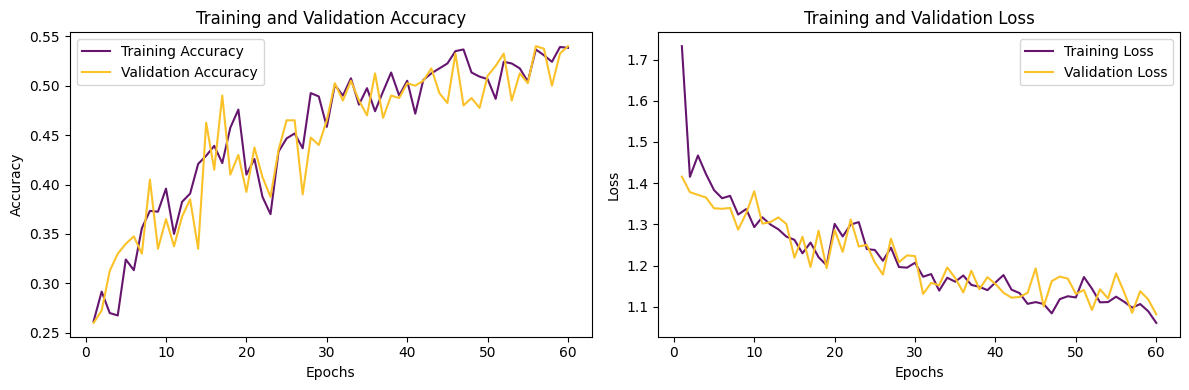

In [91]:
acc_and_loss_visualization(history, colors)

In [92]:
test_loss, test_accuracy = model.evaluate(test_dataset)

25/25 [==============================] - 4s 149ms/step - loss: 1.1246 - accuracy: 0.5250


###fine-tuned BERT

In [93]:
total_layers = len(bert_model.bert.encoder.layer)
total_layers

12

In [94]:
for layer in bert_model.bert.encoder.layer[:total_layers - 4]:
  layer.trainable = False

In [95]:
bert_output = bert_model(input_ids, attention_mask=attention_mask)[1]
x = Dense(128, activation='relu')(bert_output)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [96]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [97]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[metric]
  )

In [99]:
checkpoint_filepath_2 = path + 'models/' + 'ft_bert.hdf5'

callbacks = [

    EarlyStopping(
      monitor = 'val_accuracy',
      patience = 30,
      mode = 'max',
      verbose = 1
  ),

    ModelCheckpoint(
      filepath = checkpoint_filepath_2,
      monitor = 'val_accuracy',
      verbose = 1,
      mode = 'max',
      save_best_only = True
  )

]

In [100]:
EPOCHS = 60

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks = callbacks
  )

Epoch 1/60
19/19 [==============================] - ETA: 0s - loss: 1.8548 - accuracy: 0.2600
Epoch 1: val_accuracy improved from -inf to 0.27000, saving model to /content/drive/MyDrive/Задание 5/models/ft_bert.hdf5
19/19 [==============================] - 37s 1s/step - loss: 1.8548 - accuracy: 0.2600 - val_loss: 1.4143 - val_accuracy: 0.2700
Epoch 2/60
19/19 [==============================] - ETA: 0s - loss: 1.4099 - accuracy: 0.2867
Epoch 2: val_accuracy improved from 0.27000 to 0.31750, saving model to /content/drive/MyDrive/Задание 5/models/ft_bert.hdf5
19/19 [==============================] - 29s 2s/step - loss: 1.4099 - accuracy: 0.2867 - val_loss: 1.3787 - val_accuracy: 0.3175
Epoch 3/60
19/19 [==============================] - ETA: 0s - loss: 1.4141 - accuracy: 0.2967
Epoch 3: val_accuracy improved from 0.31750 to 0.36500, saving model to /content/drive/MyDrive/Задание 5/models/ft_bert.hdf5
19/19 [==============================] - 17s 938ms/step - loss: 1.4141 - accuracy: 0.296

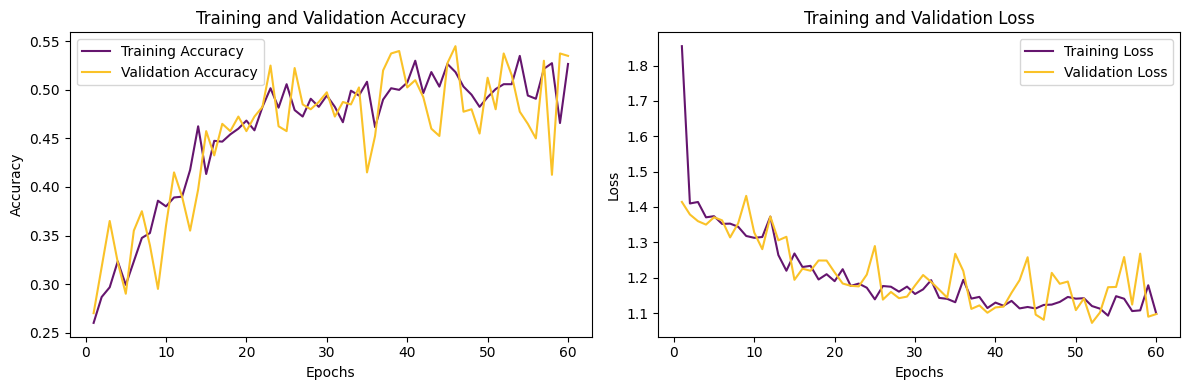

In [101]:
acc_and_loss_visualization(history, colors)

In [102]:
test_loss, test_accuracy = model.evaluate(test_dataset)

25/25 [==============================] - 4s 150ms/step - loss: 1.1259 - accuracy: 0.5425


#LSTM

Подготовка данных для LSTM

In [103]:
# Создаем токенизатор и обучаем его на всех текстах
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Преобразуем тексты в последовательности целых чисел
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Определяем максимальную длину последовательности
max_length = max([len(x) for x in train_sequences])

# Дополняем последовательности до максимальной длины
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1  # Размер словаря

Создание и обучение LSTM модели

In [104]:
lstm_model = Sequential()

lstm_model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=256,
        input_length=max_length
      )
    )

lstm_model.add(LSTM(256, return_sequences=True))

lstm_model.add(Dropout(0.1))

lstm_model.add(LSTM(256))

lstm_model.add(Dropout(0.001))

lstm_model.add(Dense(4, activation='softmax'))

In [105]:
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    #optimizer=tf.keras.optimizers.Adam(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
  )

In [106]:
checkpoint_filepath_3 = path + 'models/' + 'lstm_model.hdf5'

callbacks = [

    EarlyStopping(
      monitor = 'val_accuracy',
      patience = 20,
      mode = 'max',
      verbose = 1
  ),

    ModelCheckpoint(
      filepath = checkpoint_filepath_3,
      monitor = 'val_accuracy',
      verbose = 1,
      mode = 'max',
      save_best_only = True
  )

]

In [107]:
EPOCHS = 60

history_lstm = lstm_model.fit(
    train_padded,
    train_labels,
    validation_data = (val_padded, val_labels),
    epochs = EPOCHS,
    batch_size = 32,
    callbacks = callbacks
  )

Epoch 1/60
38/38 [==============================] - ETA: 0s - loss: 1.4879 - accuracy: 0.2367
Epoch 1: val_accuracy improved from -inf to 0.27500, saving model to /content/drive/MyDrive/Задание 5/models/lstm_model.hdf5
38/38 [==============================] - 59s 1s/step - loss: 1.4879 - accuracy: 0.2367 - val_loss: 1.4338 - val_accuracy: 0.2750
Epoch 2/60
38/38 [==============================] - ETA: 0s - loss: 1.4594 - accuracy: 0.2425
Epoch 2: val_accuracy did not improve from 0.27500
38/38 [==============================] - 58s 2s/step - loss: 1.4594 - accuracy: 0.2425 - val_loss: 1.4349 - val_accuracy: 0.2525
Epoch 3/60
38/38 [==============================] - ETA: 0s - loss: 1.4624 - accuracy: 0.2450
Epoch 3: val_accuracy did not improve from 0.27500
38/38 [==============================] - 58s 2s/step - loss: 1.4624 - accuracy: 0.2450 - val_loss: 1.4842 - val_accuracy: 0.2450
Epoch 4/60
38/38 [==============================] - ETA: 0s - loss: 1.4640 - accuracy: 0.2533
Epoch 4: v

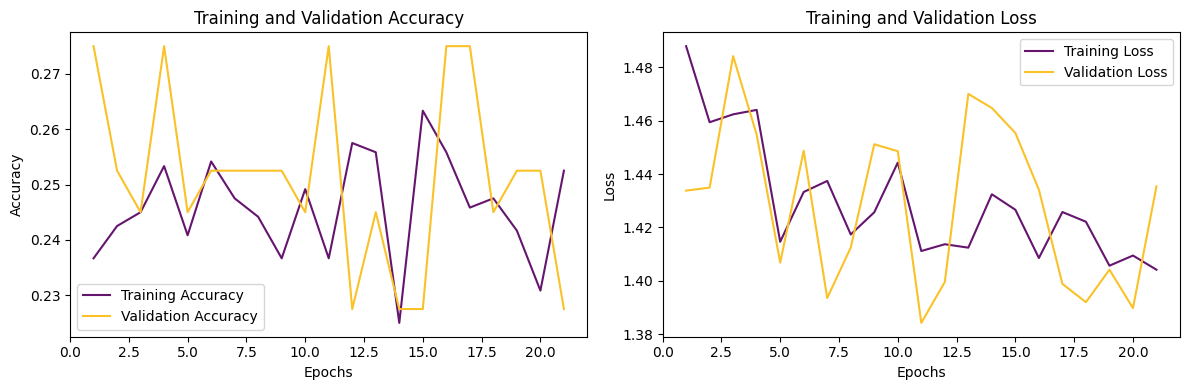

In [109]:
acc_and_loss_visualization(history_lstm, colors)

In [110]:
result = lstm_model.evaluate(test_padded, test_labels)
print(result)

13/13 [==============================] - 7s 493ms/step - loss: 1.3994 - accuracy: 0.2825
[1.399434208869934, 0.2824999988079071]


#Двунаправленная LSTM

In [111]:
vocab_size = len(tokenizer.word_index) + 1

In [112]:
bilstm_model = Sequential()

bilstm_model.add(
    Embedding(
        input_dim = vocab_size,
        output_dim = 128,
        input_length = max_length
      )
    )

bilstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))

bilstm_model.add(Dropout(0.2))

bilstm_model.add(Bidirectional(LSTM(128)))

bilstm_model.add(Dense(64, activation='relu'))

bilstm_model.add(Dense(4, activation='softmax'))

In [113]:
bilstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
  )

In [114]:
checkpoint_filepath_4 = path + 'models/' + 'bilstm_model.hdf5'

callbacks = [

    EarlyStopping(
      monitor = 'val_accuracy',
      patience = 20,
      mode = 'max',
      verbose = 1
  ),

    ModelCheckpoint(
      filepath = checkpoint_filepath_4,
      monitor = 'val_accuracy',
      verbose = 1,
      mode = 'max',
      save_best_only = True
  )

]

In [115]:
EPOCHS = 60

history_bilstm = bilstm_model.fit(
    train_padded,
    train_labels,
    validation_data = (val_padded, val_labels),
    epochs = EPOCHS,
    batch_size = 32,
    callbacks = callbacks
  )

Epoch 1/60
38/38 [==============================] - ETA: 0s - loss: 1.3035 - accuracy: 0.3667
Epoch 1: val_accuracy improved from -inf to 0.44750, saving model to /content/drive/MyDrive/Задание 5/models/bilstm_model.hdf5
38/38 [==============================] - 80s 2s/step - loss: 1.3035 - accuracy: 0.3667 - val_loss: 1.1328 - val_accuracy: 0.4475
Epoch 2/60
38/38 [==============================] - ETA: 0s - loss: 0.4870 - accuracy: 0.8075
Epoch 2: val_accuracy improved from 0.44750 to 0.71250, saving model to /content/drive/MyDrive/Задание 5/models/bilstm_model.hdf5
38/38 [==============================] - 63s 2s/step - loss: 0.4870 - accuracy: 0.8075 - val_loss: 0.8342 - val_accuracy: 0.7125
Epoch 3/60
38/38 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9733
Epoch 3: val_accuracy improved from 0.71250 to 0.77750, saving model to /content/drive/MyDrive/Задание 5/models/bilstm_model.hdf5
38/38 [==============================] - 65s 2s/step - loss: 0.0865 - acc

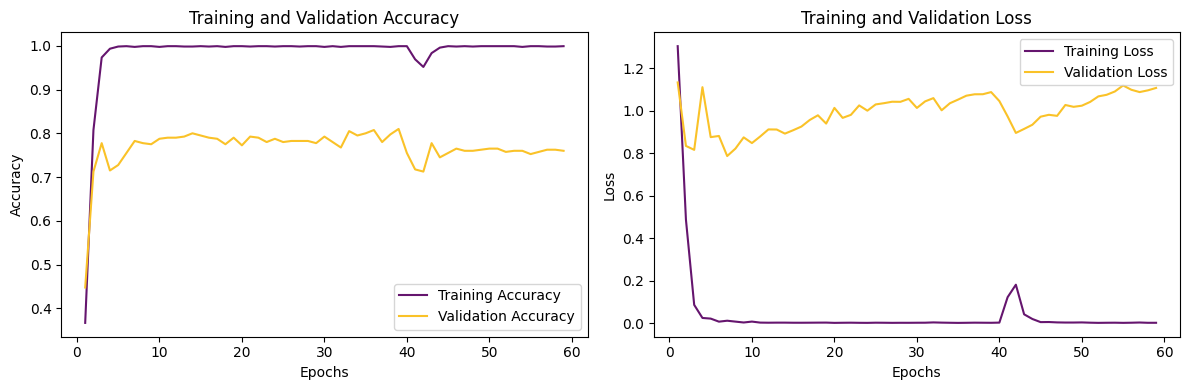

In [118]:
acc_and_loss_visualization(history_bilstm, colors)

In [117]:
result = bilstm_model.evaluate(test_padded, test_labels)
print(result)

13/13 [==============================] - 7s 559ms/step - loss: 1.0324 - accuracy: 0.7475
[1.0324389934539795, 0.7475000023841858]
